## Query OSM Data for VT and Build Road Network
---

Authors: Joseph Holler

Reproduction Materials Available at: https://github.com/samroubin/VTPharmacy/tree/main

Created: `2024-01-14`
Revised: `2024-01-29`

### Purpose
This notebook was used only to query OpenStreetMap data and build and save a network graph of roads in and near Vermont.
This road graph has been saved and provided with the research compendium on OSF because the CyberGISX system with public resources is too slow to query and process the data from OSM.

### Computational Environment
In order for OSMNX to work in a new environment, it is highly recommended to install with these instructions https://osmnx.readthedocs.io/en/stable/installation.html to create a new environment with the OSMNX package: 
```
conda create -n ox -c conda-forge --strict-channel-priority osmnx
```
Or create a new environment and install OSMNX as the first package. 
This notebook was run with Python version 3.12.1 and osmnx version 1.8.1.

### Modules
Import necessary libraries to run this model.
See `environment.yml` for the library versions used for this analysis.

In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
from IPython.display import display, clear_output
from shapely.ops import nearest_points   #for hospital_setting function
import warnings
import os
from shapely.geometry import Point, LineString, Polygon
import sys

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))
print("Python version:", sys.version)

C:\Users\josephh\AppData\Local\Temp\ipykernel_3696\4252823739.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


pandas==2.2.0
geopandas==0.14.2
networkx==3.2.1
osmnx==1.8.1
Python version: 3.12.1 | packaged by conda-forge | (main, Dec 23 2023, 07:53:56) [MSC v.1937 64 bit (AMD64)]


## Check Directories


In [2]:
# Check working directory
os.getcwd()

'D:\\github\\samroubin\\VTPharmacy\\procedure\\code'

In [3]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'D:\\github\\samroubin\\VTPharmacy'

### Load the Road Network

If `Vermont_Network_Buffer.graphml` does not already exist, this cell will query the road network from OpenStreetMap.  

Each of the road network code blocks may take a few mintues to run.

In [4]:
%%time
# To create a new graph from OpenStreetMap, delete or rename the graph file (if it exists)
# AND set OSM to True
# This is more likely to work on a local computer than CyberGISX
OSM = True

# Define the place name for Vermont
place_name_vermont = 'Vermont, USA'

roads_path = "./data/raw/private/osm_roads.graphml"

# if buffered street network is not saved, and OSM is preferred, generate a new graph from OpenStreetMap and save it
if not os.path.exists(roads_path) and OSM:
    print("Loading buffered Vermont road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Vermont', network_type='drive', buffer_dist=64373.8) 
    print("Saving road network to", roads_path, " Please wait...", flush=True)
    ox.save_graphml(G, roads_path)
    print("Data saved.")
    
# otherwise, if buffered street network is not saved, download graph from the OSF project
elif not os.path.exists(roads_path):
    print("Downloading buffered Vermont road network from OSF...", flush=True)
    url = 'https://osf.io/download/n2q73/'  
    r = requests.get(url, allow_redirects=True)
    print("Saving road network to", roads_path, " Please wait...", flush=True)
    open(roads_path, 'wb').write(r.content)
    
# load the saved network graph
if os.path.exists(roads_path):
    print("Loading road network from", roads_path, "Please wait...", flush=True)
    G = ox.load_graphml(roads_path) 
    print("Data loaded.") 
else:
    print("Error: could not load the road network from file.")

Loading road network from ./data/raw/private/osm_roads.graphml Please wait...
Data loaded.
CPU times: total: 41.9 s
Wall time: 42.7 s


### Plot the Road Network

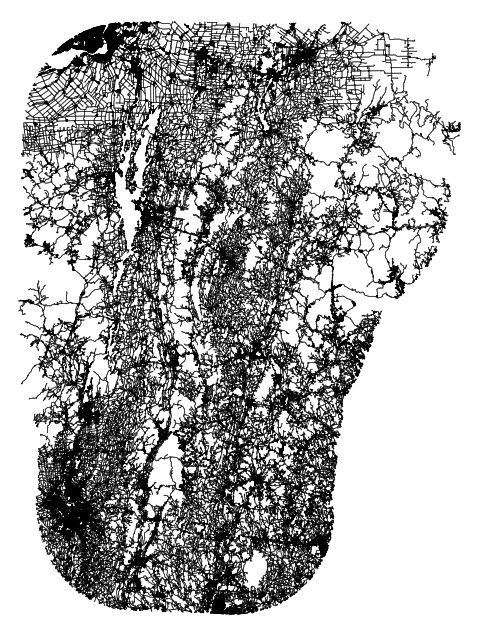

CPU times: total: 34.5 s
Wall time: 35.4 s


(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [6]:
%%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

In [7]:
%%time
# Turn network edges into a geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Count frequency of each speed value
speed_values = edges['maxspeed'].value_counts()

# Ouput number of edges and frequences of speed values
print(str(len(edges)) + " edges in graph")
print(speed_values.to_string())

577399 edges in graph
maxspeed
30 mph                                              48848
40                                                  20564
30                                                  18812
50                                                  15082
25 mph                                              14227
35 mph                                              10340
40 mph                                               9657
55 mph                                               6035
45 mph                                               5790
50 mph                                               3702
70                                                   2089
20 mph                                               1343
90                                                   1246
100                                                  1005
65 mph                                                722
[40 mph, 30 mph]                                      470
15 mph                                   

Display all the unique highway types, which are used to impute the speed limits for each category of highway.

In [8]:
# view all highway types
print(edges['highway'].value_counts())

highway
residential                              383310
tertiary                                  65237
secondary                                 37717
primary                                   37419
unclassified                              37235
trunk                                      7176
motorway_link                              3150
motorway                                   1912
[residential, unclassified]                 939
primary_link                                833
tertiary_link                               659
secondary_link                              635
trunk_link                                  551
[residential, tertiary]                     152
living_street                               149
[tertiary, unclassified]                     50
[unclassified, tertiary]                     47
[secondary, tertiary]                        33
road                                         29
rest_area                                    26
busway                          